Based on paper https://arxiv.org/abs/1412.6572
Apply Targeted Fast Gradient Sign Method (TFGSM), exploiting trained model prediction error to add some noise in the input image to maximize the error, in an iterative manner.

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

Load trained model

In [2]:
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')
model.trainable = False

Load and preprocess input image, following ResNet50 scaling

In [3]:
img = tf.io.read_file('chat.jpg')
img = tf.image.decode_jpeg(img)
img = tf.cast(img, tf.float32)
img = tf.image.resize(img, (224, 224))
img = preprocess_input(img)

Set classes index, according to ImageNET: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/


In [4]:
teapot_idx = 849
cat_idx = 283

Define $ϵ$ step to apply based on produced loss

In [5]:
e = 1

Give a picture of cat as input while let the model know that it is a teapot (when it is actually a cat)

In [6]:
target = np.zeros((1, 1000))
target[0, teapot_idx] = 1.0
target = tf.Variable(target)

Define loss and initialize tensor

In [7]:
criterion = tf.keras.losses.CategoricalCrossentropy()
X = tf.expand_dims(img, axis=0)
X = tf.Variable(X, trainable=True)
print(X.shape)

(1, 224, 224, 3)


Optimization process.
1. Pass the image $X$ through the trained model
2. Calculate loss between target (teapot) and output (produced guess from model, initially a cat).
3. Calculate the gradient between the loss and input (how the input "weights" should be updated to minimize the loss)
4. apply this gradient on the image $X$ using step $\epsilon$
5. Repeat until convergence, that is until model predict a teapot

In [8]:
cnt = 0
for i in range(100):
    with tf.GradientTape() as tape:
        output = model(X, training=False)
        loss = -1 * criterion(target, output)
    gradients = tape.gradient(loss, X)
    gradients = tf.sign(gradients)
    X_adv = X + e * gradients
    result = tf.clip_by_value(X_adv, 0, 1)
    X.assign(X_adv)

    _, y_pred = tf.math.top_k(model(X_adv, training=False), k=1)
    print(y_pred)

    if y_pred.numpy()[0][0] == teapot_idx:
        cnt += 1
    if cnt >= 5:
      break

tf.Tensor([[133]], shape=(1, 1), dtype=int32)
tf.Tensor([[849]], shape=(1, 1), dtype=int32)
tf.Tensor([[849]], shape=(1, 1), dtype=int32)
tf.Tensor([[849]], shape=(1, 1), dtype=int32)
tf.Tensor([[849]], shape=(1, 1), dtype=int32)
tf.Tensor([[849]], shape=(1, 1), dtype=int32)


Reverse preprocessing of ImageNet

In [9]:
mean = [103.939, 116.779, 123.68]
x = X_adv[0].numpy()
x[..., 0] += mean[0]
x[..., 1] += mean[1]
x[..., 2] += mean[2]
x = x[..., ::-1]
x = tf.convert_to_tensor(x)

Display and save the image. Still actually looks like a cat even it is predicted as a teapot.

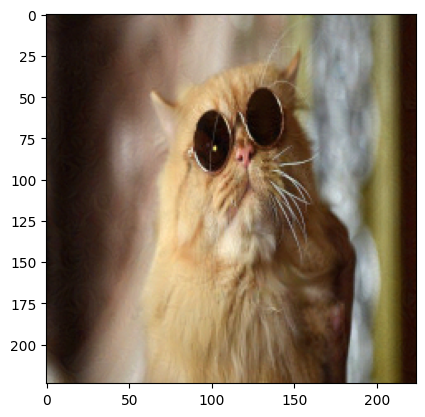

In [10]:
from tensorflow.keras.utils import array_to_img

img_display = array_to_img(x, data_format=None, scale=True)
plt.imshow(img_display)
plt.show()

tf.keras.preprocessing.image.save_img('chat2.jpg', img_display)

Below the verification script

In [11]:
# Python 3.11.3
import numpy as np
import tensorflow as tf
from urllib import request

from PIL import Image
# from TresTresSecret import drapeau
import matplotlib.pyplot as plt

file = 'chat2.jpg'

je_merite_le_drapeau = True
chat_modifie = Image.open(file)

# Modèle utilisé : ResNet50 de TensorFlow
model = tf.keras.applications.resnet50.ResNet50(weights='imagenet')

# Mise du chat dans le réseau
image_raw = tf.io.read_file(file)
image = tf.image.decode_image(image_raw)


# Prétraitement de l'image : on utilise directement la fonction de ResNet50
# plt.imshow(image * 0.5 + 0.5)
# plt.show()
image = tf.cast(image, tf.float32)
image = tf.image.resize(image, (224, 224))
image = tf.keras.applications.resnet50.preprocess_input(image)
image = image[None, ...]

# Prédiction de l'image
image_probs = model.predict(image)
_, image_class, class_confidence = tf.keras.applications.resnet50.decode_predictions(image_probs, top=1)[0][0]
_, y_pred = tf.math.top_k(model(image, training=False), k=1)
print(y_pred)
print(image_class, class_confidence)

# On vérifie que c'est bien une théière
if image_class != 'teapot':
    je_merite_le_drapeau = False

# On cherche le vrai chat
chat = Image.open('chat.jpg')
taille = chat.size

# On utilise la norme L2
def distance(a, b):
    return np.linalg.norm(np.array(a) - np.array(b))

# On vérifie enfin si le chat n'a pas été trop ~modifié~~
eps = 70
for x in range(taille[0]):
    for y in range(taille[1]):
        if distance(chat.getpixel((x, y)), chat_modifie.getpixel((x, y))) > eps:
            je_merite_le_drapeau = False
if je_merite_le_drapeau:
    print(f'Je mérite le drapeau.')
else:
    print('Je ne mérite pas le drapeau')

35363/35363 [==============================] - 0s 0us/step
tf.Tensor([[849]], shape=(1, 1), dtype=int32)
teapot 0.18925472
Je mérite le drapeau.
